In [1]:
from iter_cropping import CroppingDataGenerator
from iter_semantic import SemanticDataGenerator

In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
import numpy as np

In [4]:
tissuenet_dir = "/data/tissuenet"
from file_utils import _load_npz, load_data
(X_train, y_train), (X_val, y_val) = load_data(tissuenet_dir)

Loaded train.npz: X.shape: (2580, 512, 512, 2), y.shape (2580, 512, 512, 2)
Loaded val_256x256.npz: X.shape: (3118, 256, 256, 2), y.shape (3118, 256, 256, 2)


In [5]:
smaller = 16
if smaller:
    X_train, y_train = X_train[:smaller], y_train[:smaller]
    X_val, y_val = X_val[:smaller], y_val[:smaller]

In [6]:
datagen_val = SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0,
    data_format="channels_last",
)

In [7]:
rotation_range=180
shear_range=0
zoom_min=0.75
horizontal_flip=True
vertical_flip=True
crop_size=256
seed=0
min_objects=0
data_format='channels_last'
zoom_range=(zoom_min, 1 / zoom_min)

In [8]:
datagen = CroppingDataGenerator(
    rotation_range=rotation_range,
    shear_range=shear_range,
    zoom_range=(zoom_min, 1 / zoom_min),
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip,
    crop_size=(crop_size, crop_size),
    data_format=data_format,
)

In [9]:
from mesmer import mesmer_preprocess
import matplotlib.pyplot as plt

In [10]:
X_train = mesmer_preprocess(X_train)

In [11]:
train_dict = {"X": X_train, "y": y_train}

In [12]:
X_val = mesmer_preprocess(X_val)

In [13]:
val_dict = {"X": X_val, "y": y_val}

In [14]:
print(train_dict["X"].shape)
print(train_dict["y"].shape)

(16, 512, 512, 2)
(16, 512, 512, 2)


In [15]:
seed = 0
min_objects = 0
batch_size = 16

In [16]:
val_data = datagen_val.flow(
    val_dict,
    seed=seed,
    transforms=["inner-distance", "pixelwise"],
    transforms_kwargs={
        "pixelwise": {"dilation_radius": 1},
        "inner-distance": {"erosion_width": 1, "alpha": "auto"},
    },
    min_objects=min_objects,
    batch_size=batch_size,
    shuffle=False
)

In [17]:
train_data = datagen.flow(
    train_dict,
    seed=seed,
    transforms=["inner-distance", "pixelwise"],
    transforms_kwargs={
        "pixelwise": {"dilation_radius": 1},
        "inner-distance": {"erosion_width": 1, "alpha": "auto"},
    },
    min_objects=0,
    batch_size=batch_size,
    shuffle=False,
)


In [18]:
X_batch, y_batch = train_data.next()

In [19]:
transforms=["inner-distance", "pixelwise"]
transforms_kwargs={
    "pixelwise": {"dilation_radius": 1},
    "inner-distance": {"erosion_width": 1, "alpha": "auto"},
}
channel_axis=-1
data_format="channels_last"

In [20]:
from deepcell.image_generators import _transform_masks

In [21]:
class SemanticDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y, transforms=['outer-distance'], transforms_kwargs={}):
        self.X = X
        self.y = y
        self.transforms = transforms
        self.transforms_kwargs = transforms_kwargs
        self.channel_axis=3

    def _transform_labels(self, y):
        y_semantic_list = []
        # loop over channels axis of labels in case there are multiple label types
        for label_num in range(y.shape[self.channel_axis]):
    
            if self.channel_axis == 1:
                y_current = y[:, label_num:label_num + 1, ...]
            else:
                y_current = y[..., label_num:label_num + 1]
    
            for transform in self.transforms:
                transform_kwargs = self.transforms_kwargs.get(transform, dict())
                y_transform = _transform_masks(y_current, transform,
                                               data_format=data_format,
                                               **transform_kwargs)
                y_semantic_list.append(y_transform)

        y_semantic_list = [ys[0] for ys in y_semantic_list]
        return y_semantic_list

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if idx>=self.__len__():
            raise IndexError('list index out of range')

        # if torch.is_tensor(idx):
        #     idx = idx.tolist()

        # img_name = os.path.join(self.root_dir,
        #                         self.landmarks_frame.iloc[idx, 0])
        # image = io.imread(img_name)
        # landmarks = self.landmarks_frame.iloc[idx, 1:]
        # landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
        # sample = {'image': image, 'landmarks': landmarks}

        # if self.transform:
        #     sample = self.transform(sample)

        # return sample

        return (self.X[idx], self._transform_labels(self.y[idx:idx+1])  )


In [22]:
import scipy

In [23]:
class CroppingDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y, rotation_range, shear_range, zoom_range, horizontal_flip, vertical_flip, crop_size, transforms=['outer-distance'], transforms_kwargs={}):
        self.X = X
        self.y = y
        self.transforms = transforms
        self.transforms_kwargs = transforms_kwargs
        self.channel_axis=3
        self.seed = 0
        self.rotation_range = rotation_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.crop_size = (crop_size, crop_size)
        self.row_axis = 1
        self.col_axis = 2
        self.interpolation_order = 1
        self.fill_mode="nearest"
        self.cval=0.0

    def _transform_labels(self, y):
        y_semantic_list = []
        # loop over channels axis of labels in case there are multiple label types
        for label_num in range(y.shape[self.channel_axis]):
    
            if self.channel_axis == 1:
                y_current = y[:, label_num:label_num + 1, ...]
            else:
                y_current = y[..., label_num:label_num + 1]
    
            for transform in self.transforms:
                transform_kwargs = self.transforms_kwargs.get(transform, dict())
                y_transform = _transform_masks(y_current, transform,
                                               data_format=data_format,
                                               **transform_kwargs)
                y_semantic_list.append(y_transform)

        y_semantic_list = [ys[0] for ys in y_semantic_list]
        return y_semantic_list

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.seed is not None and idx%4==0:
            np.random.seed(self.seed + idx//4)

        def get_random_transform_base(img_shape, seed=None):
            """Generates random parameters for a transformation.
    
            Args:
                img_shape: Tuple of integers.
                    Shape of the image that is transformed.
                seed: Random seed.
    
            Returns:
                A dictionary containing randomly chosen parameters describing the
                transformation.
            """
            img_row_axis = self.row_axis - 1
            img_col_axis = self.col_axis - 1
    
            if seed is not None:
                np.random.seed(seed)
    
            if self.rotation_range:
                theta = np.random.uniform(-self.rotation_range, self.rotation_range)
            else:
                theta = 0
            
            if self.shear_range:
                shear = np.random.uniform(-self.shear_range, self.shear_range)
            else:
                shear = 0
    
            if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
                zx, zy = 1, 1
            else:
                zx, zy = np.random.uniform(
                    self.zoom_range[0], self.zoom_range[1], 2
                )
    
            flip_horizontal = (np.random.random() < 0.5) * self.horizontal_flip
            flip_vertical = (np.random.random() < 0.5) * self.vertical_flip
    
            transform_parameters = {
                "theta": theta,
                "shear": shear,
                "tx": 0,
                "ty": 0,
                "zx": zx,
                "zy": zy,
                "channel_shift_intensity": None,
                "brightness": None,
                "flip_horizontal": flip_horizontal,
                "flip_vertical": flip_vertical,
            }
    
            return transform_parameters


        def get_random_transform(img_shape, seed=None):
            transform_parameters = get_random_transform_base(
                img_shape=img_shape, seed=seed)
    
            crop_indices = None
            if self.crop_size is not None:
    
                img_dims = img_shape[1:] if self.channel_axis == 1 else img_shape[:2]
                if img_dims == self.crop_size:
                    # don't need to crop
                    pass
                elif img_dims[0] == self.crop_size[0] or img_dims[1] == self.crop_size[1]:
                    raise ValueError('crop_size must be a subset of both axes or exactly '
                                     ' equal to image dims')
                elif img_dims[0] < self.crop_size[0] or img_dims[1] < self.crop_size[1]:
                    raise ValueError('Crop dimensions must be smaller than image dimensions')
                else:
                    row_start = np.random.randint(0, img_dims[0] - self.crop_size[0])
                    col_start = np.random.randint(0, img_dims[1] - self.crop_size[1])
                    crop_indices = ([row_start, row_start + self.crop_size[0]],
                                    [col_start, col_start + self.crop_size[1]])
    
            transform_parameters['crop_indices'] = crop_indices
    
            return transform_parameters

        def random_transform(x, y=None, seed=None):
            """Applies a random transformation to an image.
    
            Args:
                x (numpy.array): 3D tensor or list of 3D tensors,
                    single image.
                y (numpy.array): 3D tensor or list of 3D tensors,
                    label mask(s) for ``x``, optional.
                seed (int): Random seed.
    
            Returns:
                numpy.array: A randomly transformed copy of the input (same shape).
                If ``y`` is passed, it is transformed if necessary and returned.
            """
            params = get_random_transform(x.shape, seed)
    
            x = apply_transform(x, params)
    
            # Nullify the transforms that don't affect `y`
            params['brightness'] = None
            params['channel_shift_intensity'] = None
            _interpolation_order = self.interpolation_order
            self.interpolation_order = 0
    
            if isinstance(y, list):
                y_new = []
                for y_i in y:
                    if y_i.shape[self.channel_axis - 1] > 1:
                        y_t = apply_transform(y_i, params)
    
                    # Keep original interpolation order if it is a
                    # regression task
                    elif y_i.shape[self.channel_axis - 1] == 1:
                        self.interpolation_order = _interpolation_order
                        y_t = apply_transform(y_i, params)
                        self.interpolation_order = 0
                    y_new.append(y_t)
                y = y_new
            else:
                y = apply_transform(y, params)
    
            self.interpolation_order = _interpolation_order
            return x, y

        
        def apply_affine_transform(
            x,
            theta=0,
            tx=0,
            ty=0,
            shear=0,
            zx=1,
            zy=1,
            row_axis=1,
            col_axis=2,
            channel_axis=0,
            fill_mode="nearest",
            cval=0.0,
            order=1,
        ):
            """Applies an affine transformation specified by the parameters given.
        
            DEPRECATED.
            """
            # Input sanity checks:
            # 1. x must 2D image with one or more channels (i.e., a 3D tensor)
            # 2. channels must be either first or last dimension
            if np.unique([row_axis, col_axis, channel_axis]).size != 3:
                raise ValueError(
                    "'row_axis', 'col_axis', and 'channel_axis' must be distinct"
                )
        
            # shall we support negative indices?
            valid_indices = set([0, 1, 2])
            actual_indices = set([row_axis, col_axis, channel_axis])
            if actual_indices != valid_indices:
                raise ValueError(
                    f"Invalid axis' indices: {actual_indices - valid_indices}"
                )
        
            if x.ndim != 3:
                raise ValueError("Input arrays must be multi-channel 2D images.")
            if channel_axis not in [0, 2]:
                raise ValueError(
                    "Channels are allowed and the first and last dimensions."
                )
        
            transform_matrix = None
            if theta != 0:
                theta = np.deg2rad(theta)
                rotation_matrix = np.array(
                    [
                        [np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta), np.cos(theta), 0],
                        [0, 0, 1],
                    ]
                )
                transform_matrix = rotation_matrix
        
            if tx != 0 or ty != 0:
                shift_matrix = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]])
                if transform_matrix is None:
                    transform_matrix = shift_matrix
                else:
                    transform_matrix = np.dot(transform_matrix, shift_matrix)
        
            if shear != 0:
                shear = np.deg2rad(shear)
                shear_matrix = np.array(
                    [[1, -np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]]
                )
                if transform_matrix is None:
                    transform_matrix = shear_matrix
                else:
                    transform_matrix = np.dot(transform_matrix, shear_matrix)
        
            if zx != 1 or zy != 1:
                zoom_matrix = np.array([[zx, 0, 0], [0, zy, 0], [0, 0, 1]])
                if transform_matrix is None:
                    transform_matrix = zoom_matrix
                else:
                    transform_matrix = np.dot(transform_matrix, zoom_matrix)
        
            if transform_matrix is not None:
                h, w = x.shape[row_axis], x.shape[col_axis]
                transform_matrix = transform_matrix_offset_center(
                    transform_matrix, h, w
                )
                x = np.rollaxis(x, channel_axis, 0)
        
                # Matrix construction assumes that coordinates are x, y (in that order).
                # However, regular numpy arrays use y,x (aka i,j) indexing.
                # Possible solution is:
                #   1. Swap the x and y axes.
                #   2. Apply transform.
                #   3. Swap the x and y axes again to restore image-like data ordering.
                # Mathematically, it is equivalent to the following transformation:
                # M' = PMP, where P is the permutation matrix, M is the original
                # transformation matrix.
                if col_axis > row_axis:
                    transform_matrix[:, [0, 1]] = transform_matrix[:, [1, 0]]
                    transform_matrix[[0, 1]] = transform_matrix[[1, 0]]
                final_affine_matrix = transform_matrix[:2, :2]
                final_offset = transform_matrix[:2, 2]
        
                channel_images = [
                    scipy.ndimage.interpolation.affine_transform(
                        x_channel,
                        final_affine_matrix,
                        final_offset,
                        order=order,
                        mode=fill_mode,
                        cval=cval,
                    )
                    for x_channel in x
                ]
                x = np.stack(channel_images, axis=0)
                x = np.rollaxis(x, 0, channel_axis + 1)
            return x

        def apply_transform_base(x, transform_parameters):
            """Applies a transformation to an image according to given parameters.
    
            Args:
                x: 3D tensor, single image.
                transform_parameters: Dictionary with string - parameter pairs
                    describing the transformation.
                    Currently, the following parameters
                    from the dictionary are used:
                    - `'theta'`: Float. Rotation angle in degrees.
                    - `'tx'`: Float. Shift in the x direction.
                    - `'ty'`: Float. Shift in the y direction.
                    - `'shear'`: Float. Shear angle in degrees.
                    - `'zx'`: Float. Zoom in the x direction.
                    - `'zy'`: Float. Zoom in the y direction.
                    - `'flip_horizontal'`: Boolean. Horizontal flip.
                    - `'flip_vertical'`: Boolean. Vertical flip.
                    - `'channel_shift_intensity'`: Float. Channel shift intensity.
                    - `'brightness'`: Float. Brightness shift intensity.
    
            Returns:
                A transformed version of the input (same shape).
            """
            # x is a single image, so it doesn't have image number at index 0
            img_row_axis = self.row_axis - 1
            img_col_axis = self.col_axis - 1
            img_channel_axis = self.channel_axis - 1

            import keras
            x = keras.preprocessing.image.apply_affine_transform(
            # x = apply_affine_transform(
                x,
                transform_parameters.get("theta", 0),
                transform_parameters.get("tx", 0),
                transform_parameters.get("ty", 0),
                transform_parameters.get("shear", 0),
                transform_parameters.get("zx", 1),
                transform_parameters.get("zy", 1),
                row_axis=img_row_axis,
                col_axis=img_col_axis,
                channel_axis=img_channel_axis,
                fill_mode=self.fill_mode,
                cval=self.cval,
                order=self.interpolation_order,
            )
    
            if transform_parameters.get("flip_horizontal", False):
                x = flip_axis(x, img_col_axis)
    
            if transform_parameters.get("flip_vertical", False):
                x = flip_axis(x, img_row_axis)
        
            return x

        def transform_matrix_offset_center(matrix, x, y):
            o_x = float(x) / 2 - 0.5
            o_y = float(y) / 2 - 0.5
            offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
            reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
            transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
            return transform_matrix

        def flip_axis(x, axis):
            x = np.asarray(x).swapaxes(axis, 0)
            x = x[::-1, ...]
            x = x.swapaxes(0, axis)
            return x

        
        def apply_transform(x, transform_parameters):

            if transform_parameters['crop_indices'] is not None:
                row_indices, col_indices = transform_parameters['crop_indices']
                if self.channel_axis == 1:
                    x = x[:, row_indices[0]:row_indices[1], col_indices[0]:col_indices[1]]
                else:
                    x = x[row_indices[0]:row_indices[1], col_indices[0]:col_indices[1], :]

            x = apply_transform_base(
                x=x, transform_parameters=transform_parameters)
            return x
        
        x = self.X[idx]
        
        y_semantic_list = self._transform_labels(self.y[idx:idx+1]) 

        x, y_semantic_list = random_transform(x, y_semantic_list)

        import copy
        return (copy.deepcopy(x), copy.deepcopy(y_semantic_list))


In [24]:
import torch

In [66]:
class CroppingDatasetTorch(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y, rotation_range, shear_range, zoom_range, horizontal_flip, vertical_flip, crop_size, transforms=['outer-distance'], transforms_kwargs={}):
        self.X = X
        self.y = y
        self.transforms = transforms
        self.transforms_kwargs = transforms_kwargs
        self.channel_axis=3
        self.seed = 0
        self.rotation_range = rotation_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.crop_size = (crop_size, crop_size)
        self.row_axis = 1
        self.col_axis = 2
        self.interpolation_order = 1
        self.fill_mode="nearest"
        self.cval=0.0

    def _transform_labels(self, y):
        y_semantic_list = []
        # loop over channels axis of labels in case there are multiple label types
        for label_num in range(y.shape[self.channel_axis]):
    
            if self.channel_axis == 1:
                y_current = y[:, label_num:label_num + 1, ...]
            else:
                y_current = y[..., label_num:label_num + 1]
    
            for transform in self.transforms:
                transform_kwargs = self.transforms_kwargs.get(transform, dict())
                y_transform = _transform_masks(y_current, transform,
                                               data_format=data_format,
                                               **transform_kwargs)
                y_semantic_list.append(y_transform)

        y_semantic_list = [ys[0] for ys in y_semantic_list]
        return y_semantic_list

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.seed is not None and idx%4==0:
            np.random.seed(self.seed + idx//4)
            torch.manual_seed(self.seed+idx//4)

        from torchvision.transforms import v2 as transforms

        # Create a Compose object with a list of transformations
        transform = transforms.Compose([
            transforms.ToImage(),          # Convert the image to a PyTorch tensor
            # transforms.ToDtype(torch.float32, scale=True),
            transforms.RandomCrop(256),
            transforms.RandomRotation(degrees=180),
            transforms.RandomResizedCrop(size=256, scale=(0.75, 1/0.75)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5)
        ])

        x = self.X[idx]
        y_semantic_list = self._transform_labels(self.y[idx:idx+1]) 

        # state = torch.get_rng_state()

        # x = transform(x)
        # for k in range(len(y_semantic_list)):
        #     torch.set_rng_state(state)
        #     y_semantic_list[k] = transform(y_semantic_list[k])

        li = transform([x]+[y_semantic_list[k] for k in range(len(y_semantic_list))])
        x = li[0]
        y_semantic_list = li[1:]
        
        return (x, y_semantic_list)


In [67]:
sd = SemanticDataset(X_val, y_val, transforms=transforms, transforms_kwargs=transforms_kwargs)

In [68]:
cd = CroppingDataset(X_train, y_train, rotation_range, shear_range, zoom_range, horizontal_flip, vertical_flip, crop_size, transforms=transforms, transforms_kwargs=transforms_kwargs)

In [69]:
cdt = CroppingDatasetTorch(X_train, y_train, rotation_range, shear_range, zoom_range, horizontal_flip, vertical_flip, crop_size, transforms=transforms, transforms_kwargs=transforms_kwargs)

In [104]:
dataloader = DataLoader(cdt, batch_size=8, shuffle=False, num_workers=4)

In [105]:
dataiter = iter(dataloader)

In [106]:
tmp = None

In [108]:
X_sd, y_sd = next(dataiter)
print(X_sd.size())
print(len(y_sd))
print(y_sd[3].shape)
if tmp is None:
    tmp = X_sd
else:
    assert(not torch.equal(tmp, X_sd))
    tmp = X_sd

torch.Size([8, 2, 256, 256])
4
torch.Size([8, 3, 256, 256])


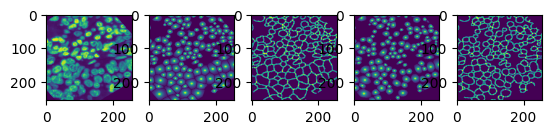

In [109]:
fig, axs = plt.subplots(1, 5)
idx = 6
ch = 0
sample = X_sd[idx, ch, ...]
labels = y_sd
axs[0].imshow(sample)
axs[1].imshow(labels[0][idx, ch, ...])
axs[2].imshow(labels[1][idx, ch, ...])
axs[3].imshow(labels[2][idx, ch, ...])
axs[4].imshow(labels[3][idx, ch, ...])
plt.show()

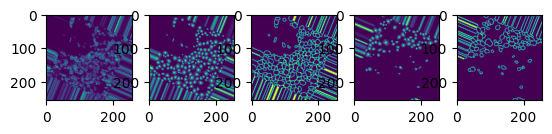

In [33]:
fig, axs = plt.subplots(1, 5)
idx = 1
ch = 0
sample = X_batch[idx, ..., ch]
labels = y_batch
axs[0].imshow(sample)
axs[1].imshow(labels[0][idx, ..., ch])
axs[2].imshow(labels[1][idx, ..., ch])
axs[3].imshow(labels[2][idx, ..., ch])
axs[4].imshow(labels[3][idx, ..., ch])
plt.show()

ValueError: operands could not be broadcast together with shapes (256,256) (2,256) 

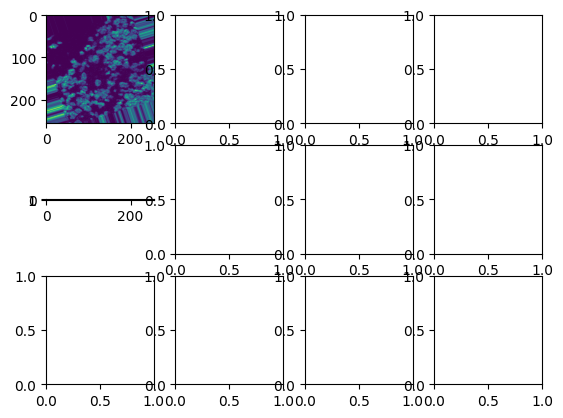

In [34]:
fig, axs = plt.subplots(3, 4)
for i in range(4):
    ch = 0
    img_a = X_batch[i, ..., ch]
    img_b = X_sd[i, ..., ch]
    # img_b = X_sd[i, ch, ...]

    axs[0, i].imshow(img_a)
    axs[1, i].imshow(img_b)
    axs[2, i].imshow(img_a-np.array(img_b))
    print(np.mean(img_a-np.array(img_b)))

In [ ]:
fig, axs = plt.subplots(3, 4)
for i in range(4):
    ch = 0
    img_a = y_batch[i][1, ..., ch]
    
    img_b = np.array(y_sd[i][1, ch, ...])
    img_b = np.array(y_sd[i][1, ..., ch])

    axs[0, i].imshow(img_a)
    axs[1, i].imshow(img_b)
    axs[2, i].imshow(img_a-np.array(img_b))
    print(np.mean(img_a-np.array(img_b)))